# Building Detector
In this notebook, I will run experiments to try to create a building detector that works in both urban and rural parts of Africa.

First let's figure out how to display images:

In [8]:
import IPython.display

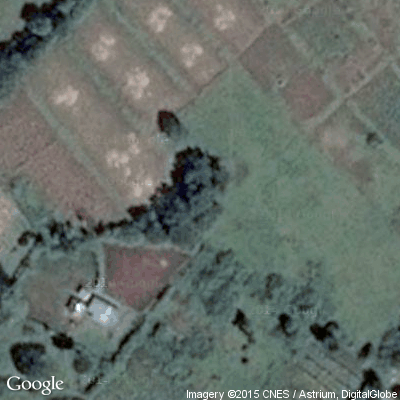

In [9]:
imageDir = '../images/'
IPython.display.Image(filename=imageDir+'test_images/test1.png')

Now let's try to do some template matching with the following very simple, gray, 10x10 pixel template. Before we start, let's explore some of the properties of the template:

In [10]:
IPython.display.Image(imageDir + 'templates/template1.png')

That is what our template looks like. Let's see how we can manipulate the pixels within our template:

In [11]:
from PIL import Image

In [12]:
template1 = Image.open(imageDir + 'templates/template1.png')
# Returns the dimensions of the template in pixels
print 'The dimensions of the template are {}'.format(template1.size)
# Return RGBA (alpha) value of the pixel
pixels1 = template1.load()
print pixels1[1,1]

The dimensions of the template are (10, 10)
(227, 227, 227, 255)


We will try to make one of the pixels in our template red.

In [13]:
pixels1[1,1] = (220, 20, 60, 255)

In [14]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

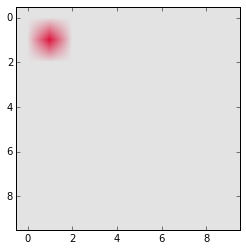

In [15]:
plt.imshow(np.asarray(template1))

## Template matching with scikit-image
The first thing that I want to try to do is slide the template across the image and return the resulting map that shows how well the template matches at each point of the image. Template matching functions are offered by scikit-image and by opencv--here is an example using scikit-learn taken from this [link](http://scikit-image.org/docs/dev/auto_examples/plot_template.html).

In [16]:
from skimage import data
from skimage.feature import match_template

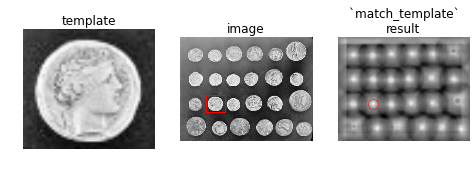

In [17]:
# Loading in an image of coins
image = data.coins()
# Setting the template as a single coin in the image
coin = image[170:220, 75:130]
# Matching the template, with input padded
result = match_template(image, coin, pad_input=True)
# Finding the index of the max of the template-matching result
ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]

# Creating a figure to display results
# figsize is (width, height) in inches
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(8, 3))
# Displaying the template
ax1.imshow(coin, cmap=plt.cm.Greys_r)
ax1.set_axis_off()
ax1.set_title('template')
# Displaying the original image
ax2.imshow(image, cmap=plt.cm.Greys_r)
ax2.set_axis_off()
ax2.set_title('image')
# Adding a bounding box around the matched region
hcoin, wcoin = coin.shape
rect = plt.Rectangle((x - wcoin / 2 - 1, y - hcoin / 2 - 1), wcoin, hcoin, edgecolor='r', facecolor='none')
ax2.add_patch(rect)
# Displaying the match_template result
ax3.imshow(result, cmap=plt.cm.Greys_r)
ax3.set_axis_off()
ax3.set_title('`match_template`\nresult')
# Circle the maximum response point
ax3.autoscale(False)
ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

plt.show()

### Template matching test image 1
Let's use the gray template and our first test image to try some template-matching.

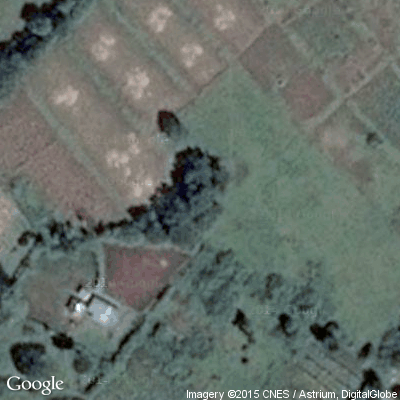

In [18]:
IPython.display.Image(filename=imageDir+'test_images/test1.png')

In [19]:
IPython.display.Image(imageDir + 'templates/template1.png')

Instead of using PIL to import images (which caused some weird thing to happen where the color satellite image had only one channel), from now on I'll try to use OpenCV whenever possible.

In [20]:
import cv2

(400, 400)
(10, 10)


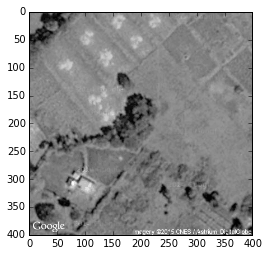

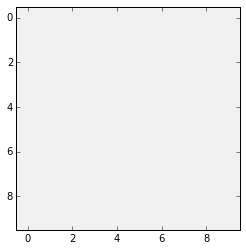

In [171]:
# Satellite image as grayscale array
test1 = cv2.imread(imageDir + 'test_images/test1.png', 0)
print test1.shape
# Display grayscale satellite image
fig1 = plt.figure()
plt.imshow(test1, cmap=plt.cm.Greys_r, vmin=0, vmax=255)

# Template as grayscale array
temp1 = cv2.imread(imageDir + 'templates/template1.png', 0)
print temp1.shape
height, width = temp1.shape
# Display grayscale template
fig2 = plt.figure()
plt.imshow(temp1, cmap=plt.cm.Greys_r, vmin=0, vmax=255)

In [172]:
# Matching the template without padding input
result1 = cv2.matchTemplate(test1, temp1, method=cv2.TM_SQDIFF_NORMED)
print result1.shape
print result1[:5,:5]

# Find max result location
ij = np.unravel_index(np.argmin(result1), result1.shape)
x,y = ij[::-1]

(391, 391)
[[ 0.54265028  0.53477168  0.52370614  0.51132697  0.50115061]
 [ 0.5333491   0.52530855  0.51413357  0.50181305  0.49153778]
 [ 0.52737033  0.5196988   0.50768912  0.49484068  0.48390776]
 [ 0.5232296   0.51575619  0.50357115  0.49054518  0.47827446]
 [ 0.5221436   0.51508385  0.50212246  0.48899612  0.47572881]]


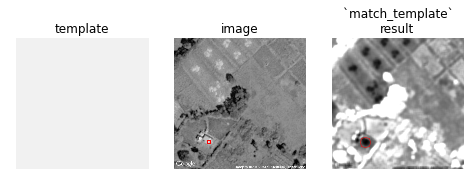

In [173]:
# Creating a figure to display results
# figsize is (width, height) in inches
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(8, 3))
# Displaying the template
ax1.imshow(temp1, cmap=plt.cm.Greys_r, vmin=0, vmax=255)
ax1.set_axis_off()
ax1.set_title('template')
# Displaying the original image
ax2.imshow(test1, cmap=plt.cm.Greys_r, vmin=0, vmax=255)
ax2.set_axis_off()
ax2.set_title('image')
# Adding a bounding box around the matched region
rect = plt.Rectangle((x, y), width, height, edgecolor='r', facecolor='none')
ax2.add_patch(rect)
# Displaying the match_template result
ax3.imshow(result1, cmap=plt.cm.Greys_r)
ax3.set_axis_off()
ax3.set_title('`match_template`\nresult')
# Circle the maximum response point
ax3.autoscale(False)
ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

plt.show()

In the code above, we found the maximum value in the template-matching result, but what if we want to find all pixels where the result is above a certain threshold?

Let's plot a histogram of the values in the result first:

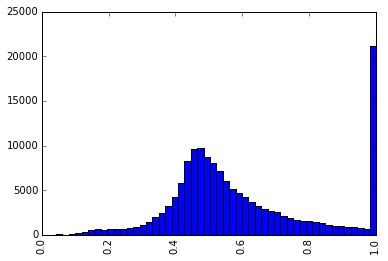

In [174]:
# Make result array into vector
res1 = np.hstack(result1)
# Plot histogram of result values
plt.hist(res1, bins=50)
plt.xticks(rotation='vertical')
plt.show()

It seems like a good threshold might be around 0.1. Let's try that and see what happens.

In [175]:
# Threshold for template matching
threshold = 0.1

# Finding the locations where the difference is less than the threshold
loc = np.where(result1 <= threshold)

Now that we have all the locations, let's paint them red on the original image so that we can see what kinds of things we are finding.

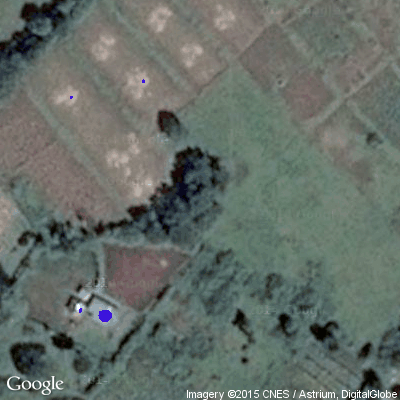

In [176]:
# Satellite image as RGB array
test1 = cv2.imread(imageDir + 'test_images/test1.png')

# Set all pixels below threshold to red
for pt in zip(*loc[::1]):
    test1[pt[0] + width / 2,pt[1] + height / 2] = (220, 20, 60)

# Save image and then display it
cv2.imwrite(imageDir + 'output_images/test1thresholded.png', test1)
IPython.display.Image(filename=imageDir+'output_images/test1thresholded.png')

This seems like it works *OK*... let's try testing it on a few different images.

#### Test image 2

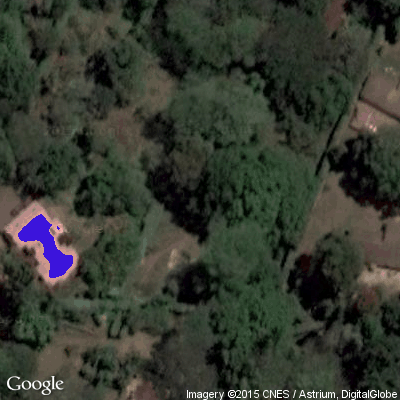

In [169]:
# Satellite image as grayscale array
test2 = cv2.imread(imageDir + 'test_images/test2.png', 0)
# Template as grayscale array
temp1 = cv2.imread(imageDir + 'templates/template1.png', 0)
height, width = temp1.shape
# Matching the template without padding input
result2 = cv2.matchTemplate(test2, temp1, method=cv2.TM_SQDIFF_NORMED)
# Find max result location
ij = np.unravel_index(np.argmin(result2), result2.shape)
x,y = ij[::-1]
# Threshold for template matching
threshold = 0.1
# Finding the locations where the difference is less than the threshold
loc = np.where(result2 <= threshold)
# Satellite image as RGB array
test2 = cv2.imread(imageDir + 'test_images/test2.png')
# Set all pixels below threshold to red
for pt in zip(*loc[::1]):
    test2[pt[0] + width / 2,pt[1] + height / 2] = (220, 20, 60)
# Save image and then display it
cv2.imwrite(imageDir + 'output_images/test2thresholded.png', test2)
IPython.display.Image(filename=imageDir+'output_images/test2thresholded.png')

#### Test image 3

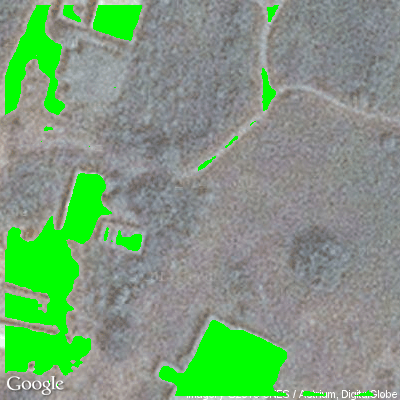

In [177]:
# Satellite image as grayscale array
test3 = cv2.imread(imageDir + 'test_images/test3.png', 0)
# Template as grayscale array
temp1 = cv2.imread(imageDir + 'templates/template1.png', 0)
height, width = temp1.shape
# Matching the template without padding input
result3 = cv2.matchTemplate(test3, temp1, method=cv2.TM_SQDIFF_NORMED)
# Find max result location
ij = np.unravel_index(np.argmin(result3), result3.shape)
x,y = ij[::-1]
# Threshold for template matching
threshold = 0.1
# Finding the locations where the difference is less than the threshold
loc = np.where(result3 <= threshold)
# Satellite image as RGB array
test3 = cv2.imread(imageDir + 'test_images/test3.png')
# Set all pixels below threshold to green
for pt in zip(*loc[::1]):
    test3[pt[0] + width / 2,pt[1] + height / 2] = (0, 255, 0)
# Save image and then display it
cv2.imwrite(imageDir + 'output_images/test3thresholded.png', test3)
IPython.display.Image(filename=imageDir+'output_images/test3thresholded.png')

This seems to be at least somewhat successful at picking out buildings (and roads too sometimes), so let's turn it into a function that takes in an image, a template, and a threshold, and outputs an image with the buildings colored green (hopefully).

### Template-matching function

In [178]:
def template_match(image, template, threshold, outImage):
    """
    This function takes in an image, a template, and a threshold, and
    creates an output image with pixels that meet the threshold colored
    green.
    :param image: The filepath of the image
    :param template: The filepath of the template
    :param threshold: The threshold to use for template-matching
    :param outImage: The filepath of the output image
    """
    # Satellite image as grayscale array
    test = cv2.imread(image, 0)
    # Template as grayscale array
    temp = cv2.imread(template, 0)
    # Pixel dimensions of template
    height, width = temp.shape
    # Matching the template
    result = cv2.matchTemplate(test, temp, method=cv2.TM_SQDIFF_NORMED)
    # Find max result location
    ij = np.unravel_index(np.argmin(result), result.shape)
    x,y = ij[::-1]
    # Finding the locations where the difference is less than the threshold
    locs = np.where(result <= threshold)
    # Satellite image as RGB array
    test = cv2.imread(image)
    # Set all pixels below threshold to green
    for pt in zip(*locs[::1]):
        test[pt[0] + width / 2,pt[1] + height / 2] = (0, 255, 0)
    # Save image
    cv2.imwrite(outImage, test)

Let's test this function by going through our test image directory and template-matching all the images.

In [193]:
import glob
import os
import time

In [196]:
inDir = '../images/test_images/'
outDir = '../images/output_images/'
template = '../images/templates/template1.png'
tempName = os.path.basename(template)
threshold = 0.1

In [197]:
for inFile in glob.glob(inDir + '*'):
    fn = os.path.basename(inFile)[:-4]
    outFile = outDir + fn + tempName
    template_match(inFile, template, threshold, outFile)

For this small sample of 10 images, the simple template-matching seems like it does a decent job, so let's test it on the 158 images that Cynthia pulled from the DHS locations.

In [195]:
inDir = '../images/DHS_in/'
outDir = '../images/DHS_out/'
template = '../images/templates/template1.png'
threshold = 0.1

startTime = time.time()

for inFile in glob.glob(inDir + '*'):
    fn = os.path.basename(inFile)[:-4]
    outFile = outDir + fn + 'thresholded.png'
    template_match(inFile, template, threshold, outFile)
    
endTime = time.time()
print 'It took {} seconds to template-match 158 images.'.format(endTime - startTime)

It took 11.6522951126 seconds to template-match 158 images.


After running it on all 158 images, it's clear that the simple template-matching procedure doesn't work so well... maybe if we adjust the template and the threshold it will work better.